In [21]:
# DEPENDENCIES and DEFAULTS
import math #.....................................Math functionality
import numpy as np #..............................Numpy for working with arrays
import matplotlib.pyplot as plt #.................Plotting functionality 

In [22]:
L = 60 #(m) Bridge span
delT = 0.005 #(s) Time-step

In [23]:
M = 2000 #(kg/m) Mass per unit length]
m = 0.5*M*L #(kg) Modal mass of mode 1
xi = 0.025 #Damping ratio
fn = 2.5 #(Hz) Bridge modal frequency
wn = 2*math.pi*fn #(rads/s) Angular modal frequency
wd = wn*math.sqrt(1-xi**2) #(rads/s) Damped angular modal frequency

In [24]:
def Duhamel(T, F):
    #Initialise a container of zeros to hold the displacement values
    U = np.zeros(len(T))
    
    #Initialise values for the cumulative sum used to calculate A and B at each time-step
    ACum_i=0 
    BCum_i=0
    
    #Cycle through the time vector and evaluate the response at each time point
    for i, t in enumerate(T):
        #Only start calculating on the second iteration (need two values for trapezoidal area calc)
        if i>0:     
            #Calculate A[i] - equation 16
            y_i = math.e**(xi*wn*T[i]) * F[i] * math.cos(wd*T[i]) #Value of integrand at current time-step
            y_im1 = math.e**(xi*wn*T[i-1]) * F[i-1] * math.cos(wd*T[i-1]) #Value of integrand at previous time-step
            Area_i = 0.5*delT*(y_i+y_im1) #Area of trapezoid
            ACum_i += Area_i #Cumulative area from t=0 to current time
            A_i = (1/(m*wd))*ACum_i #Value of A for the current time-step
            
            #Calculate B[i] - equation 17 (same notes as for A above)
            y_i = math.e**(xi*wn*T[i]) * F[i] * math.sin(wd*T[i])
            y_im1 = math.e**(xi*wn*T[i-1]) * F[i-1] * math.sin(wd*T[i-1])
            Area_i = 0.5*delT*(y_i+y_im1)
            BCum_i += Area_i
            B_i = (1/(m*wd))*BCum_i                
                  
            #Calculate the response - equation 15
            U[i] = A_i*math.e**(-xi*wn*T[i])*math.sin(wd*T[i]) - B_i * math.e**(-xi*wn*T[i])*math.cos(wd*T[i])             
            
    return U

In [25]:
def Peaks(disp, time):
    #Initialise containers to hold peaks and their times
    peaks = np.empty([1,0]) 
    times = np.empty([1,0])
    
    #Calculate slopes for each data point
    slopes = np.zeros(len(disp))
    for i, u in enumerate(disp):
        if(i<len(disp)-1):
            slopes[i] = disp[i+1]-disp[i]
    
    #Cycle through all slopes and pick out peaks
    for i, s in enumerate(slopes):
        if (i<len(slopes)-1):
            if(slopes[i+1]<0 and slopes[i]>0):
                peaks = np.append(peaks,disp[i])
                times = np.append(times,time[i])
                
    return [peaks, times]                     

In [26]:
N = 100 #Number of pedestrians that cross the bridge in the time window
window = 30*60 #(s) #Simulation window
buffer = 200 #(s) Additional seconds to allow simulation of response beyond window length (late finishers)
mp = 80 #(kg) Pedestrian mass
G = 9.81*mp #(N) Static weight of pedestrian

In [27]:
#Random variables
tStart = np.random.uniform(low=0.0, high=window, size=N) #Uniformly distributed start times
Vp = np.random.normal(loc=1.3, scale=0.125, size=N) #Normally distributed walking velocities

In [28]:
#Set up the simulation time vector
tMax = window + buffer #(s) Max time
time = np.arange(0, tMax+delT, delT) 

#Initialise containers to hold the individual forces and responses calculated for each pedestrian
crowdForce = np.zeros([N,len(time)])
crowdResponse = np.zeros([N,len(time)])

#For each pedestrian...
for i, n in enumerate(np.arange(N)):    
    vp = Vp[i] #(m/s) Walking velocity
    startTime = tStart[i] #(s) Start time    
    tCross = L/vp #(s) Crossing time
    tEnd = startTime + tCross #(s) Finish time    

    fv = 0.35*vp**3 - 1.59*vp**2 + 2.93*vp #(Hz) Pacing frequency
    DLF = 0.41*(fv-0.95) #Dynamic load factor
    
    timeVector = np.arange(0, tCross+delT, delT) #Time vector for this pedestrian
    Fv = G + abs(G*DLF*np.sin(2*math.pi*(fv/2)*timeVector)) #Static + Dynamic GRF (ignore static component)
    
    xp = vp*timeVector #Position as a function of time
    phi = np.sin(math.pi*xp/L) #Mode shape at pedestrian's location
    Fn = Fv*phi #Modal force experienced by SDoF system
    
    response = Duhamel(timeVector, Fn) #Response calculated using the Duhamel integral function
    
    #Save the GRF and response for this pedestrian at the correct position in the overal simulation records
    iStart = round(startTime/delT) #Index for start time
    crowdForce[i, iStart:iStart+len(Fn)] = Fn
    crowdResponse[i,iStart:iStart+len(Fn)] = response     

<IPython.core.display.Javascript object>


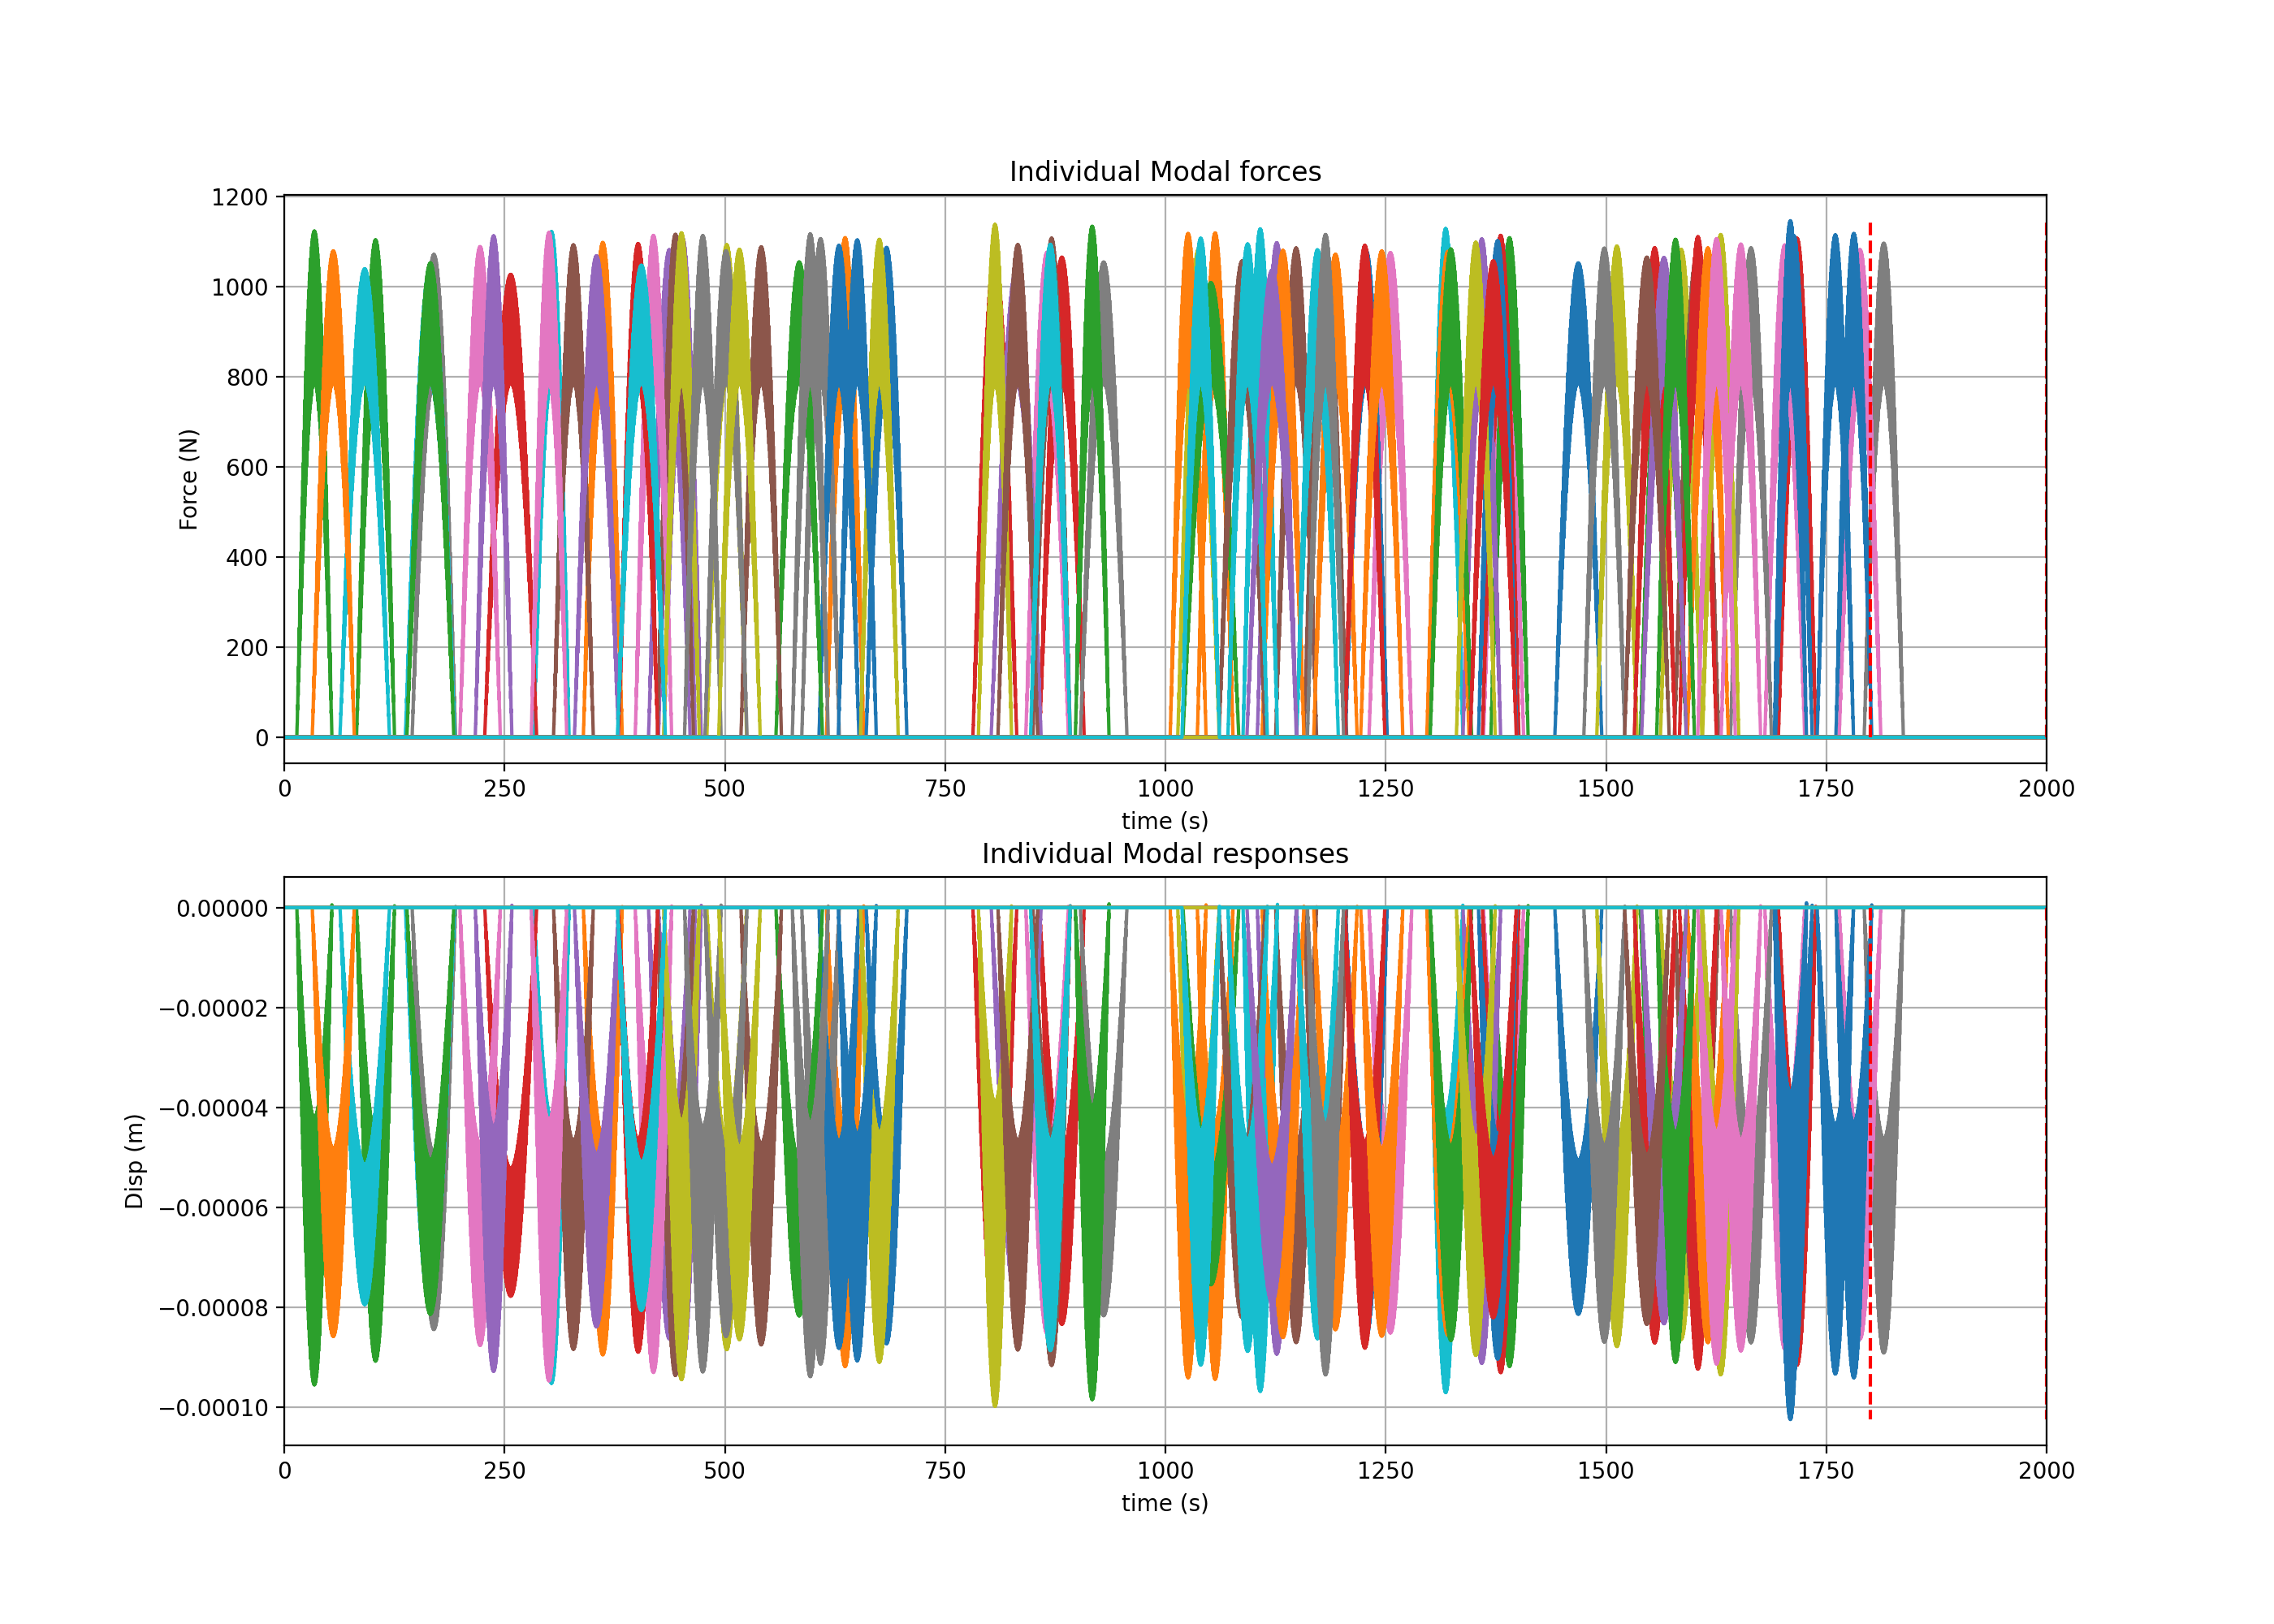

In [29]:
fig, axes = plt.subplots(figsize=(14,10),nrows=2,ncols=1)

for i in np.arange(len(crowdForce)):    
    axes[0].plot(time,crowdForce[i,:],'-')
    axes[1].plot(time,-crowdResponse[i,:],'-')

#Housekeeping
axes[0].plot([window, window],[0,np.max(crowdForce)],'r--')    
axes[0].plot([window+buffer, window+buffer],[0,np.max(crowdForce)],'r--')  
axes[0].set_xlabel('time (s)')
axes[0].set_ylabel('Force (N)')
axes[0].set_title('Individual Modal forces')
axes[0].set_xlim([0,tMax])
# axes[0].set_xlim([startTime,startTime+tCross])
axes[0].grid()

axes[1].plot([window, window],[0,-np.max(crowdResponse)],'r--')    
axes[1].plot([window+buffer, window+buffer],[0,-np.max(crowdResponse)],'r--')  
axes[1].set_xlabel('time (s)')
axes[1].set_ylabel('Disp (m)')
axes[1].set_title('Individual Modal responses')
axes[1].set_xlim([0,tMax])
# axes[1].set_xlim([startTime,startTime+tCross])
axes[1].grid()

plt.show()

In [30]:
#Sum across rows of crowdForce and crowdResponse
F_Crowd = sum(crowdForce)
Res_crowd = sum(crowdResponse)

In [31]:
peaks, times = Peaks(Res_crowd,time)

<IPython.core.display.Javascript object>


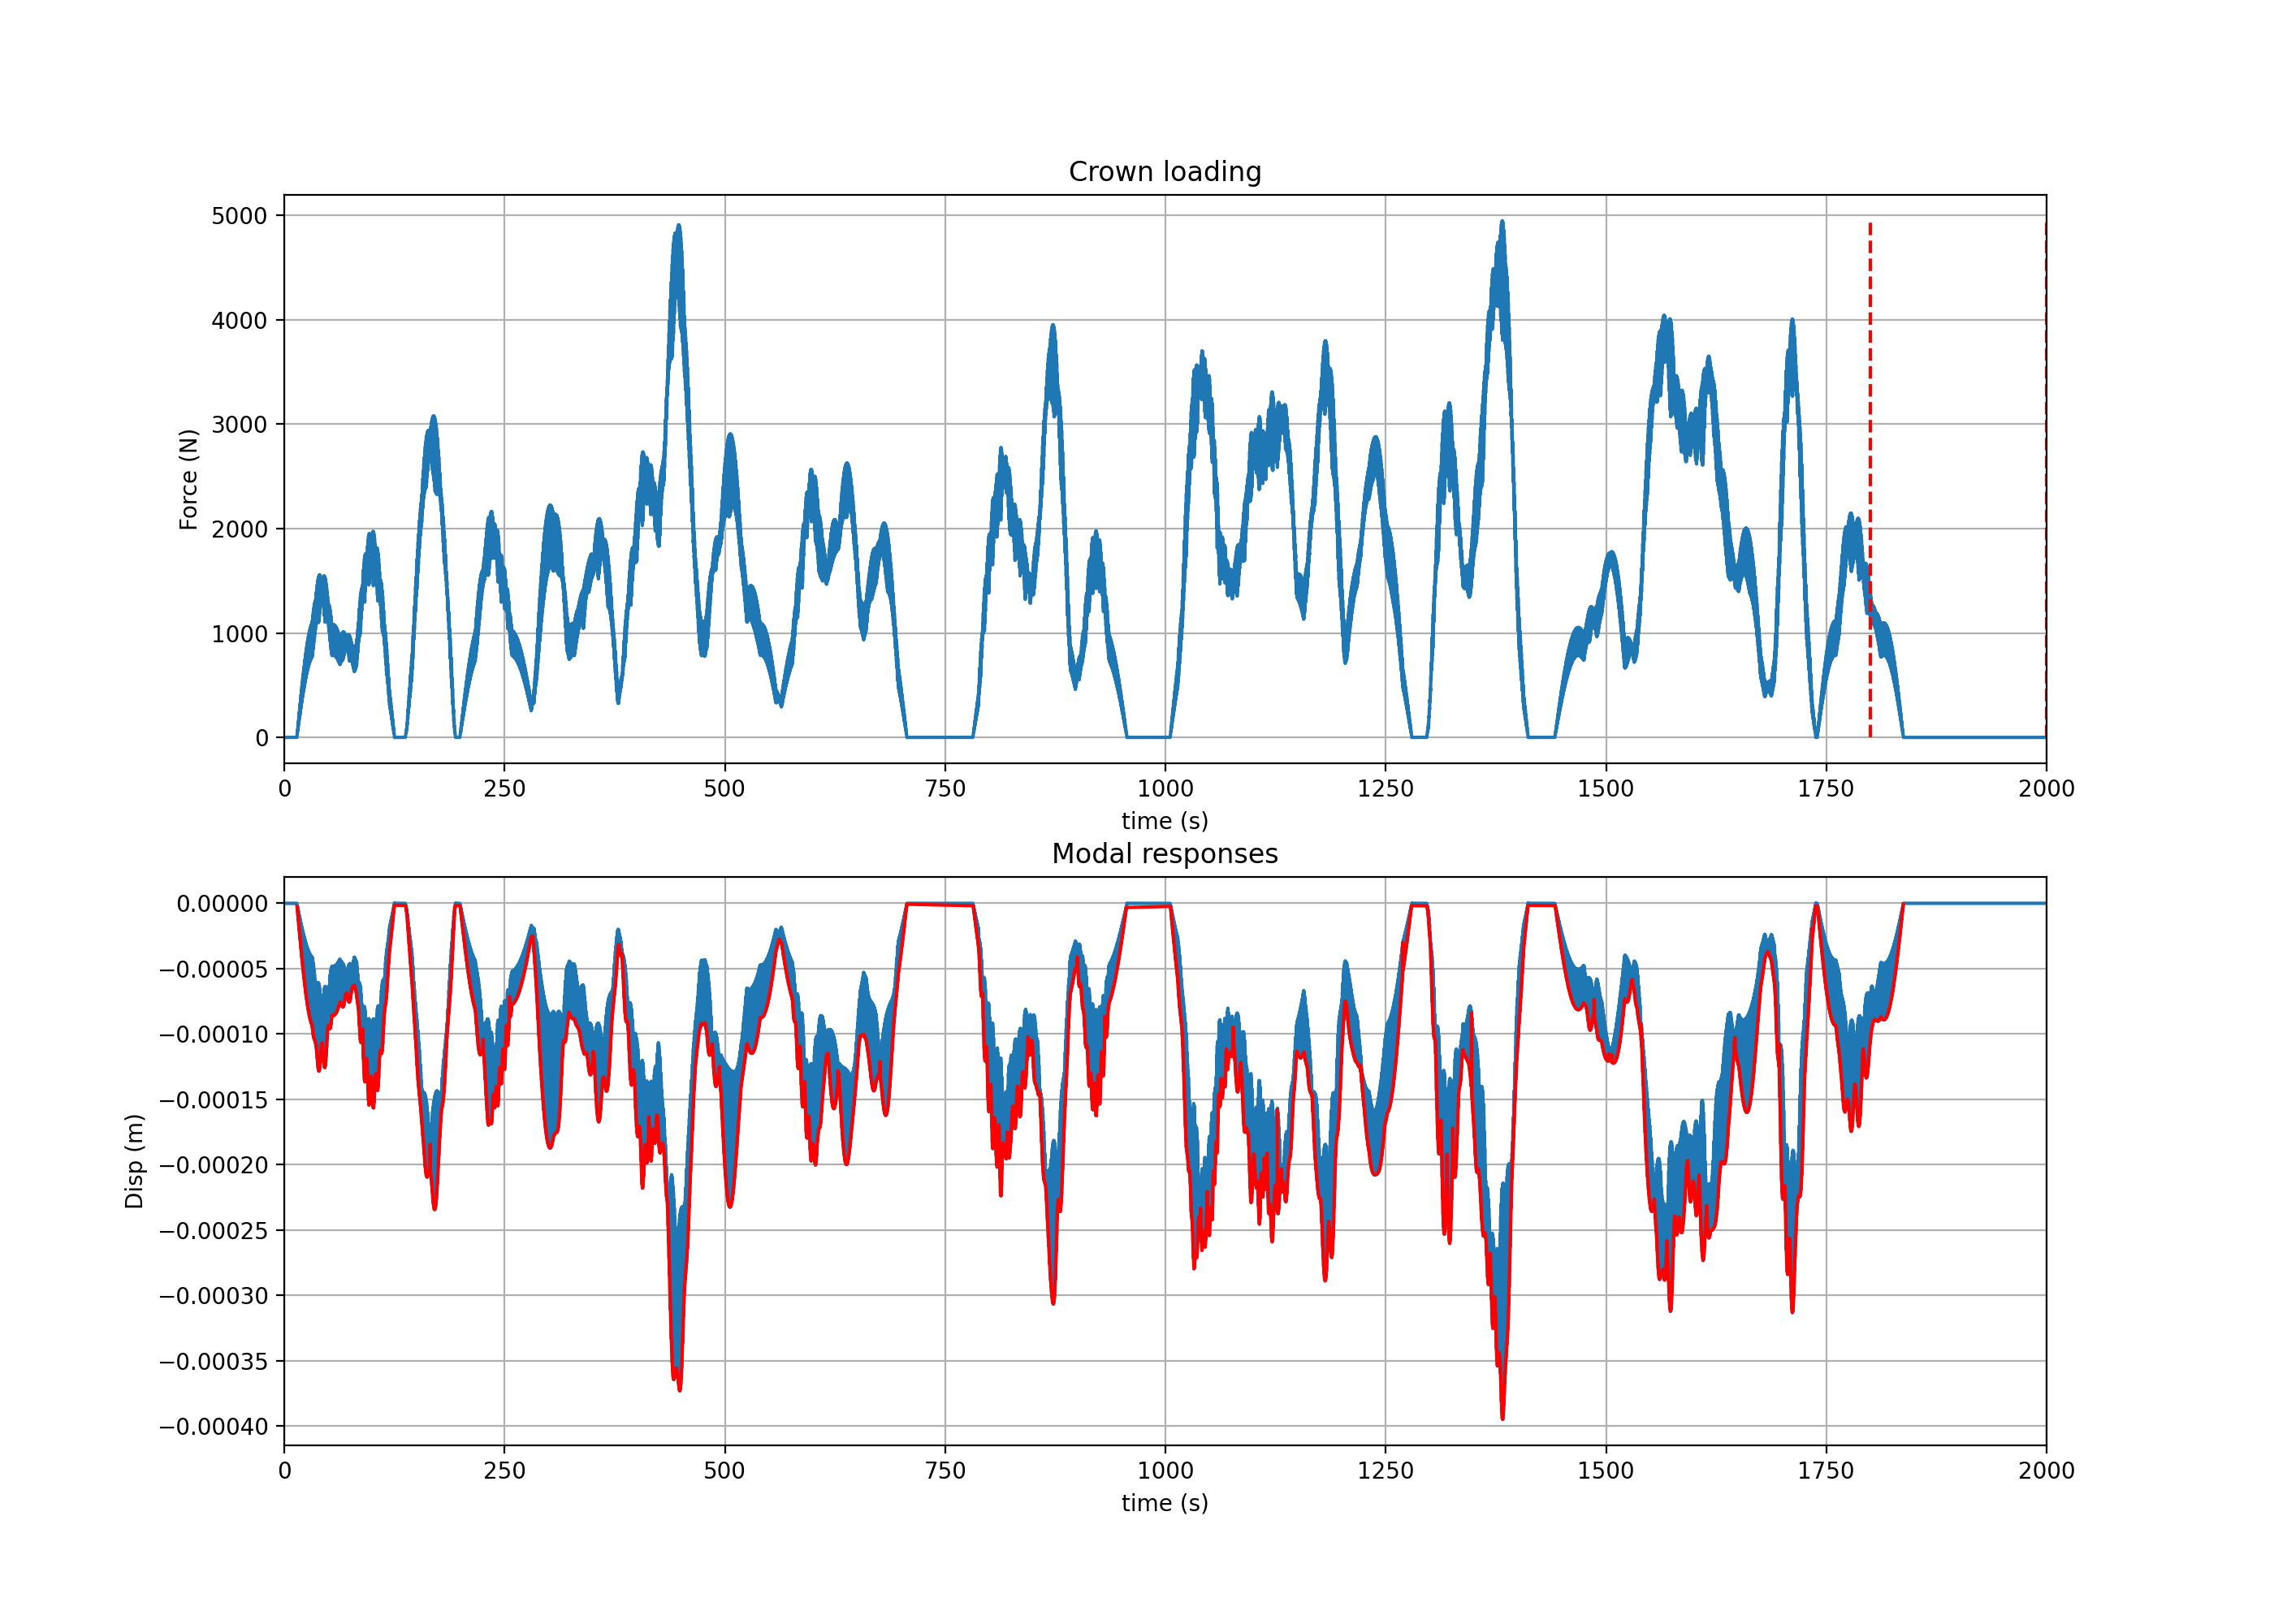

In [32]:
fig, axes = plt.subplots(figsize=(14,10),nrows=2,ncols=1) 

axes[0].plot(time,F_Crowd,'-')
axes[1].plot(time,-Res_crowd,'-')
axes[1].plot(times,-peaks,'r-')

axes[0].plot([window, window],[0,max(F_Crowd)],'r--')    
axes[0].plot([window+buffer, window+buffer],[0,max(F_Crowd)],'r--')  
axes[0].set_xlabel('time (s)')
axes[0].set_ylabel('Force (N)')
axes[0].set_title('Crown loading')
axes[0].set_xlim([0,tMax])
axes[0].grid()

axes[1].set_xlabel('time (s)')
axes[1].set_ylabel('Disp (m)')
axes[1].set_title('Modal responses')
axes[1].set_xlim([0,tMax])
axes[1].grid()

plt.show()

In [33]:
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
%matplotlib notebook

In [34]:
#Animation parameters
animLength = 100 #(sec)
frameRate = 12 #(5,10,20) frames per second (too high and animation slows down)
plotInterval = 1/frameRate #(sec) time between frame plots
dataInterval = int(plotInterval/delT) #Plot moving elements every 'dataInterval-th' point
defScale = 500 #Scale factor on bridge deflection (for visibility)

<IPython.core.display.Javascript object>


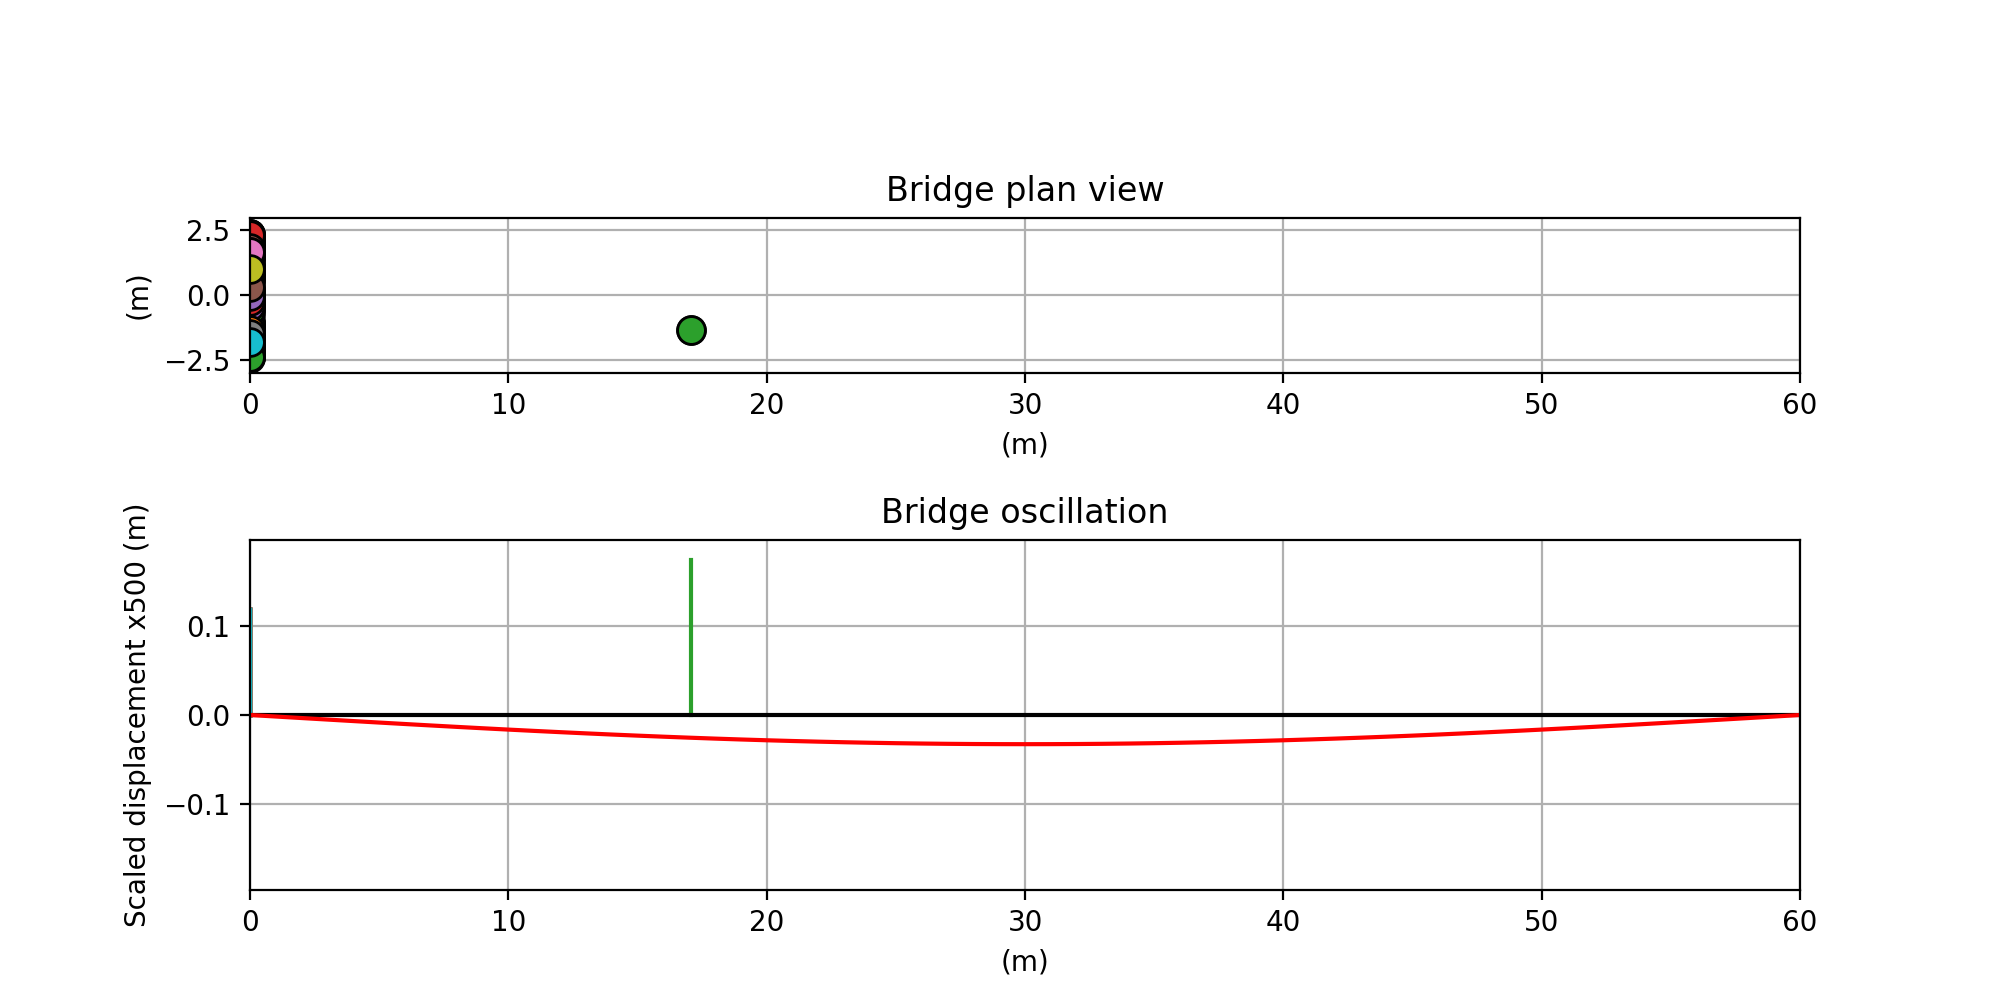

/var/folders/n0/q60d1nzd1f790rfzhjg7wsmh0000gn/T/ipykernel_3160/1067647634.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0])
/var/folders/n0/q60d1nzd1f790rfzhjg7wsmh0000gn/T/ipykernel_3160/1067647634.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(gs[1])


In [35]:
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1, figsize=(10, 5)) #Define figure and subplots
gs = gridspec.GridSpec(2,1,height_ratios=[1,1]) #Control subplot layout
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_aspect('equal', adjustable='box') #Set equal scale for axes top subplot

#Set axis limits
ax1.set_xlim([0,L])
ax1.set_ylim([-3, 3])
yLim2 = defScale*max(Res_crowd)
ax2.set_xlim([0,L])
ax2.set_ylim([-yLim2, yLim2])

#Housekeeping
ax1.set_title('Bridge plan view')
ax1.set_xlabel('(m)')
ax1.set_ylabel('(m)')
ax1.grid()

ax2.set_title('Bridge oscillation')
ax2.set_xlabel('(m)')
ax2.set_ylabel(f'Scaled displacement x{defScale} (m)')
ax2.grid()

plt.show()

In [36]:
#Define initial state of pedestrians in top plot
topPedList = [] #Initialise an empty list to hold markers representing pedestrians
for i in np.arange(N):
    yPos = np.random.uniform(low=-2.5, high=2.5, size=1) #Random positions across bridge deck width
    pedTop, = ax1.plot(0,yPos,'o', markeredgecolor='k', markersize=10)
    topPedList.append(pedTop)

#Define initial state of pedestrians in bottom plot
btmPedList = []
for i in np.arange(N):
    ped, = ax2.plot([0,0],[0,0.6*yLim2])
    btmPedList.append(ped)

#Define the initial state of the beam in the bottom plot
xVals = np.arange(0,L+1,1) #An array of x-values along the beam
phiVals = np.sin(math.pi*xVals/L) #Corresponding y-values
beamDisp = 0*phiVals #Initial array of displacements along the beam

axisLine, = ax2.plot(xVals,beamDisp,'k') #Add a horizontal beam axis to plot
defLine, = ax2.plot(xVals,beamDisp,'r') #Add initial deflected shape to plot

In [37]:
#Function to animate plot objects
def animate(i):
    frm = int(i*dataInterval) #Index of data for this frame
    simTime = time[frm] #Simulation time for this animation frame

    #Update the pedestrian positions (top plot) for the current frame
    for i in np.arange(N):
        if(simTime>tStart[i] and simTime<tStart[i] + L/Vp[i]):
            Pt = topPedList[i]
            pos = (simTime - tStart[i])*Vp[i]
            Pt.set_xdata([pos, pos])


    #Update the beam deflected shape for the current frame
    defLine.set_data(xVals, -defScale*phiVals*Res_crowd[frm])

    #Update the pedestrian positions (bottom plot) for the current frame
    for i in np.arange(N):
        if(simTime>tStart[i] and simTime<tStart[i] + L/Vp[i]):
            Pb = btmPedList[i]
            pos = (simTime - tStart[i])*Vp[i]
            h = 0.1 + 0.1*crowdForce[i,frm]/max(crowdForce[i,:])
            Pb.set_data([pos, pos],[0,h])

    return

In [ ]:
#Function to generate the animation
myAnimation = FuncAnimation(fig,
                            animate,
                            frames=int(1 + (animLength/plotInterval) ),
                            interval=plotInterval*1000,  #milliseconds
                            blit=True,
                            repeat=True)

plt.show()
myAnimation.save('Bridge_response.gif')